<a id='top'></a>

# Table of Contents
* Problem statement and motivation
* <a href='#data'>Introduction and description of data</a>
    * A revised project workflow based on the insights from EDA
    * <a href='#wrangling'>Data wrangling prior to EDA</a>
    * <a href='#eda'>Exploratory Data Analysis</a>
* <a href='#review'>Literature review / related work</a>
* <a href='#modeling'>Modeling approach and project trajectory</a>
    * <a href='#baseline'>The baseline model</a>

# Problem statement and motivation

Using user review data from Yelp, our aim was to develop a recommendation system to provide a new restaurant suggestion that a user might like. The project was motivated by the fact that recommendation problems are ubiquitious, including the infamous Netflix challenge and "similar items you might like" suggestions from Amazon. Given the diverse application of this problem, we wanted to learn how to develop and implement such system using machine learning. 

/// add a graphic here about the project goal

<a id='data'></a>
[back to top](#top)

# Introduction and description of data

![alt text](images/datasetoverview.png "Title")

The Yelp data is vast and rich: it contains millions of reviews of different business types (e.g. restaurants and dry cleaners), and each business type has different set of attributes associated with them. Each review at minimum consists of review text and review star rating. Because of its size and richness, it presented an initial challenge for us to decide what data to include in our modeling and what features should be engineered. In addition, not every user has made several reviews or reviews with different ratings, so we needed to figure out what datasets to use for training vs. testing. To this end, we performed EDA on the data, specifically to look at relevant business attributes, user attributes, and reviews. We reasoned that these are the core information needed to link users and businesses with their preferences (hence, we disregarded data such as checkin, photos, and tip). 

## A revised project workflow based on the insights from EDA
We will use the cleaned datasets to accomplish three major goals:
1. Create a baseline estimate of a rating. This simple model will be created by recording the biases of each user and item to make a baseline estimate of a given user-item combination.
2. Create a regularized regression to improve the accuracy of our baseline model.
3. Use a Neighborhood model based on a item-to-item approach as a method of collaborative filtering to improve our model further. Our initial Neighborhood model will not include features of the restaurant, but rather, similarities between restaurants based on the users that have reviewed it.


<a id='wrangling'></a>
[back to top](#top)

## Data wrangling prior to EDA

### Converting JSON files to CSV
We downloaded a 5.6 GB TAR file from Yelp. This TAR file contained second TAR file that we extracted to get a series of JSON files: business, checkin, photos, review, tip, and user. Pandas has a read_json function, but it returned a Trailing Data Error when used on these specific files. As a result, we created a Python script that converts these JSON files into CSV files. 

In [2]:
import time
import json
import pandas as pd
import numpy as np
import re
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

//anaconda/envs/snakes/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# show try again.
def json_to_csv(directory, fileNames, createSample=False):
    """
    json_to_csv: loops through specified JSON files and converts them to csv files.
                 option to also create a sample csv, which uses np.random.seed 9001 to create a sample dataset with 10% of the observations
    
                 pandas has a read_json function, but returns a 'Trailing data error' when working with these specific files
                 
                 
    Inputs: -directory of JSON files
            -list of JSON filenames
            -createSample flag
    """
    
    start = time.time()

    jsonData = []

    for fileName in fileNames:
        with open(directory + fileName,  encoding="utf8") as file:
            print('{0} opened'.format(fileName))
            for line in file:
                #I use an rstrip here because some of the files have trailing blank spaces
                jsonData.append(json.loads(line.rstrip()))
        
        df = pd.DataFrame.from_dict(jsonData)
        
        csvFileName = fileName[:len(fileName)-5] + '.csv'
        
        df.to_csv(directory + csvFileName)
        print('{0} created'.format(csvFileName))
        
        
        if createSample:
            np.random.seed(9001)
            msk = np.random.rand(len(df)) <= 0.1
            sample = df[msk]
            
            csvSampleFileName = fileName[:len(fileName)-5] + '_sample.csv'
            
            sample.to_csv(directory + csvSampleFileName)
            print('{0} created'.format(csvSampleFileName))
        
    print('This function took {} minutes to run'.format((time.time()-start)/60))

In [3]:
fileNameList = ['user.json',
                'business.json',
                'review.json']

json_to_csv('data/', fileNameList, createSample=True)

review.json opened
review.csv created
review_sample.csv created
This function took 7.314122831821441 minutes to run


### Keeping only "restaurant" business data and other associated data on users and reviews
We reduced the business dataset to businesses that had “Restaurant” or “Food” in the category (restaurants). We then removed observations that had other “non-restaurant” categories, such as “Grocery”, “Auto Glass Services”, “Business Consulting”, etc. After reducing the business dataset, we reduced our review dataset in two ways:
* Only including reviews for businesses that existed in the reduced business (restaurant) dataset 
* Only including reviews for users that have at least 2 reviews (A single rating does not help determine similarities between restaurants)
The business dataset had a variable, attributes, that was a string of a dictionary. We evaluated this string as a dictionary and applied pd.Series across the result, which expanded this dictionary into multiple Boolean columns, as well as a few more dictionary columns. All remaining dictionary columns were manipulated in the same manner, leaving us ~70 Boolean columns. The business dataset also had a variable, categories, that was a string of a list. We expanded this list into separate columns for each category. Lastly, we then reduced our user dataset by filtering to users that existed in the reduced review dataset. 

In [3]:
def find_ftres_with_nan(df):
    all_nan = df.columns[df.isnull().all()].tolist()
    some_nan = df.columns[df.isnull().any()].tolist()
    print("All NaN Features: ", len(all_nan), all_nan, "Some NaN Features: ", len(some_nan), some_nan)
    return all_nan, some_nan

In [4]:
business = pd.read_csv('data/business.csv',encoding = "ISO-8859-1",index_col=0)
all_nan, some_nan = find_ftres_with_nan(business)

//anaconda/envs/snakes/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,4,5,6,19,21,23,28,29,32,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
//anaconda/envs/snakes/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


All NaN Features:  0 [] Some NaN Features:  34 ['address', 'attributes', 'average_stars', 'business_id', 'categories', 'city', 'compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'neighborhood', 'postal_code', 'stars', 'state', 'useful', 'user_id', 'yelping_since']


Number of businesses that have both "food" and "restaurant" in their category:

In [5]:
# show
mask_restaurants = business['categories'].str.contains('Restaurants')
mask_restaurants = business['categories'].str.contains('Restaurants')
mask_food = business['categories'].str.contains('Food')
restaurants_and_food = business[mask_restaurants & mask_food]
restaurants_and_food['categories'].count()

15502

Even after taking buisnesses that have both food and restaurant in their categories, there are still irrelevant business categories in the data. 

In [6]:
# show 
restaurants_and_food.head(1)['categories'].values

array(["['Food', 'Soul Food', 'Convenience Stores', 'Restaurants']"], dtype=object)

Thus, we manually identified additional categories that needed to be excluded specifically. 

In [7]:
categoryDF = restaurants_and_food['categories'].apply(lambda x: x[1:-1].split(',')).apply(pd.Series)
uniqueCategories = pd.DataFrame(categoryDF.stack().str.strip().unique())

In [8]:
# show
categoriesToRemove = ['Grocery','Drugstores','Convenience Stores','Beauty & Spas','Photography Stores & Services',
                      'Cosmetics & Beauty Supply','Discount Store','Fashion','Department Stores','Gas Stations',
                      'Automotive','Music & Video','Event Planning & Services','Mobile Phones','Health & Medical',
                      'Weight Loss Centers','Home & Garden','Kitchen & Bath','Jewelry',"Children's Clothing",
                      'Accessories','Home Decor','Bus Tours','Auto Glass Services','Auto Detailing','Oil Change Stations',
                      'Auto Repair','Body Shops','Car Window Tinting','Car Wash','Gluten-Free','Fitness & Instruction',
                      'Nurseries & Gardening','Wedding Planning','Embroidery & Crochet','Dance Schools','Performing Arts',
                      'Wholesale Stores','Tobacco Shops','Nutritionists','Hobby Shops','Pet Services','Electronics','Plumbing',
                      'Gyms','Yoga','Walking Tours','Toy Stores','Pet Stores','Pet Groomers','Vape Shops','Head Shops',
                      'Souvenir Shops','Pharmacy','Appliances & Repair','Wholesalers','Party Equipment Rentals','Tattoo',
                      'Funeral Services & Cemeteries','Sporting Goods','Dog Walkers','Pet Boarding/Pet Sitting',
                      'Scavenger Hunts','Contractors','Trainers', 'Customized Merchandise', 'Dry Cleaning & Laundry', 
                      'Tax Law', 'Bankruptcy Law', 'Tax Services', 'Estate Planning Law', 'Business Consulting', 'Lawyers', 
                      'Pet Adoption', 'Escape Games', 'Animal Shelters', 'Commercial Real Estate', 'Real Estate Agents', 
                      'Real Estate Services', 'Home Inspectors']

In [9]:
restaurants_df = restaurants_and_food[~restaurants_and_food['categories'].str.contains('|'.join(categoriesToRemove))]

In summary, we began with 156,639 observations. 15,502 of these observations contained "Food" or "Restaurants". After removing observations with irrelevant categories, we are left with 14,032 total observations.

In [10]:
restaurants_df.to_csv('data/restaurants.csv')
restaurants_df = pd.read_csv('data/restaurants.csv', encoding='ISO-8859-1', index_col=0)
all_nan, some_nan = find_ftres_with_nan(restaurants_df)

All NaN Features:  20 ['average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 'useful', 'user_id', 'yelping_since'] Some NaN Features:  23 ['address', 'average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 'neighborhood', 'postal_code', 'useful', 'user_id', 'yelping_since']


### Expanding business attributes & categories
After cleaning the business dataset, we expanded the attributes into boolean features. 


Before expansion:

In [11]:
# show 
restaurants_df.head(1)

,address,attributes,average_stars,business_id,categories,city,compliment_cool,compliment_cute,compliment_funny,compliment_hot,...,longitude,name,neighborhood,postal_code,review_count,stars,state,useful,user_id,yelping_since
1183396,30 High Tech Rd,"{'HasTV': True, 'Caters': False, 'RestaurantsA...",NaN,reWc1g65PNZnKz_Ub9QKOQ,"['Comfort Food', 'Canadian (New)', 'Restaurant...",Richmond Hill,NaN,NaN,NaN,NaN,...,-79.429343,Milestones Restaurants,NaN,L4B 4L9,51,2.5,ON,NaN,NaN,NaN


In [12]:
# show
#create_attributes

#takes a dataframe as an input, as well as a list of columns that are dictionaries
#takes each column that is a dictionary, and expands it into a series of dummy columns


def create_attributes(df, dictList):
    
    for dictionaryColumn in dictList:
        
        #the attributes column is a string of dictionaries, so one extra step is taken to convert
        if dictionaryColumn == 'attributes':
            expandedColumns = df[dictionaryColumn].map(eval).apply(pd.Series)
        else:
            expandedColumns = df[dictionaryColumn].apply(pd.Series)
        
        df = pd.concat([df.drop(dictionaryColumn,axis=1), 
                   expandedColumns]
                  ,axis=1)
        
        #df.fillna(value='{}',inplace=True)
        
    return df

In [13]:
# show
def expand_categories(df, cat_var, key):
    all_cats = df[cat_var].str.cat(sep=', ')
    all_cats = all_cats.replace('[', '')
    all_cats = all_cats.replace(']', '')
    all_cats = all_cats.replace("\'","")
    all_cats = all_cats.replace('"','')
    all_cats_list = all_cats.split(', ')
    unique_cats = list(set(all_cats_list))
    unique_cats.remove('Restaurants')
    unique_cats.remove('Food')
    df_cats = pd.DataFrame(index=df[key], columns=unique_cats, data=False)
    df_out = df.merge(df_cats, how='left', left_on=key, right_index=True)
    for cat in unique_cats:
        df_out[cat] = df_out[cat_var].str.contains(cat)
    return df_out  

In [14]:
dictList = ['attributes', 'Ambience', 'BestNights', 'BusinessParking','Music','GoodForMeal']
expanded = create_attributes(restaurants_df[['business_id','attributes']], dictList)
dropColumns = expanded.columns.get_loc(0)
keepColumns = list(compress(expanded.columns, ~dropColumns))
expanded = expanded[keepColumns]

//anaconda/envs/snakes/lib/python3.5/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: unorderable types: int() > str(), sort order is undefined for incomparable objects
  result = result.union(other)
//anaconda/envs/snakes/lib/python3.5/site-packages/pandas/core/indexes/api.py:43: RuntimeWarning: unorderable types: int() > str(), sort order is undefined for incomparable objects
  union = _union_indexes(indexes)
//anaconda/envs/snakes/lib/python3.5/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: unorderable types: str() > int(), sort order is undefined for incomparable objects
  result = result.union(other)
//anaconda/envs/snakes/lib/python3.5/site-packages/pandas/core/indexes/api.py:43: RuntimeWarning: unorderable types: str() > int(), sort order is undefined for incomparable objects
  union = _union_indexes(indexes)


After expansion:

In [15]:
expanded.head(1)

,business_id,AgesAllowed,Alcohol,BYOB,BYOBCorkage,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,ByAppointmentOnly,Caters,...,karaoke,live,no_music,video,breakfast,brunch,dessert,dinner,latenight,lunch
1183396,reWc1g65PNZnKz_Ub9QKOQ,NaN,full_bar,NaN,NaN,True,NaN,True,NaN,False,...,False,False,False,False,False,True,True,False,False,False


In [16]:
## Join expanded with restaurants_df
restaurants_df = restaurants_df.merge(expanded, how='left', left_on='business_id', right_on='business_id')
restaurants_df.drop('attributes', axis=1, inplace=True)

In [17]:
restaurants_df = expand_categories(restaurants_df, 'categories', 'business_id')
restaurants_df.drop('categories', axis=1, inplace=True)
# Variables that won't be used
rest_vars_to_drop = ['address', 'hours', 'latitude', 'longitude', 'name']
restaurants_final = restaurants_df.drop(rest_vars_to_drop, axis=1)
restaurants_final.to_csv('data/restaurants_final.csv')

//anaconda/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


After cleaning up the business data, we kept relevant review and user data only. 

In [18]:
# show
def reduce_review(df, business_list):
    
    #drop columns where business_id or user_id is null
    df.dropna(subset=['business_id','user_id'], how='any',inplace=True)
    
    #restrict to businesses that are restaurants
    df = df[df['business_id'].isin(business_list)]
    
    #only keep user_id's with more than one review
    df = df[df.groupby('user_id').user_id.transform(len) > 1]
    
    #verify this worked by taking the minimum amount of user_id counts
    print('The minimum amount of reviews per user is {}'
          .format(np.min(df.groupby('user_id')['business_id'].count())))
    return df

In [19]:
review = pd.read_csv('data/review.csv',encoding = "ISO-8859-1",index_col=0)
restaurant_reviews = reduce_review(review, restaurants_final['business_id']) #create dataframe
_, _ = find_ftres_with_nan(restaurant_reviews) #report if there are null values

restaurant_reviews['review_date'] = pd.to_datetime(restaurant_reviews['date'])
restaurant_reviews['review_year'] = restaurant_reviews['review_date'].dt.year
restaurant_reviews['review_month'] = restaurant_reviews['review_date'].dt.month
restaurant_reviews['review_weekday'] = restaurant_reviews['review_date'].dt.weekday_name

rename_cols = {'cool': 'review_cool','funny':'review_funny','stars':'review_stars','useful':'review_useful'}
restaurant_reviews.rename(columns=rename_cols, inplace=True)
review_cols_to_drop = ['text', 'review_date', 'date']
restaurant_reviews.drop(review_cols_to_drop, axis=1, inplace=True)

//anaconda/envs/snakes/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The minimum amount of reviews per user is 2
All NaN Features:  0 [] Some NaN Features:  0 []


In [20]:
# show
restaurant_reviews.head()

,business_id,review_cool,review_funny,review_id,review_stars,review_useful,user_id,review_year,review_month,review_weekday
293,MKd_EUD0PG__cOfIbeqYAg,0,0.0,ABeny93AMSYm7Hn8UXPrRQ,5.0,1.0,3KkT6SmPFLGvBS1pnDBr8g,2011,12,Tuesday
294,MKd_EUD0PG__cOfIbeqYAg,1,1.0,KiGRD0ZhuDF1K1xLc0jjGA,4.0,2.0,TsBUWbhRhuiEMXb56kL0Cg,2012,11,Thursday
295,MKd_EUD0PG__cOfIbeqYAg,0,0.0,nGV40rXMRL_IN6lWpyrsmA,4.0,0.0,Um2iec4NKMXVpJEME3PfKg,2008,1,Thursday
296,MKd_EUD0PG__cOfIbeqYAg,10,8.0,8FvVPvTaMJAM5drD18JxAA,4.0,14.0,135DbbQnr3BEkQbBzZ9T1A,2015,2,Tuesday
297,MKd_EUD0PG__cOfIbeqYAg,0,0.0,CBamcMDNj6fCU5JbkRFgfw,4.0,0.0,3ew6BEeK14K6x6Omt5gbig,2017,5,Monday


In [21]:
restaurant_reviews.to_csv('data/restaurant_reviews_final.csv')

In [22]:
users_df = pd.read_csv('data/user.csv',encoding = "ISO-8859-1",index_col=0)
users_w_reviews = users_df[users_df['user_id'].isin(restaurant_reviews['user_id'])].copy()

list_user_vars = ['average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 
                  'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 
                  'compliment_photos', 'compliment_plain', 'compliment_profile', 
                  'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 
                  'name', 'review_count', 'useful']
vars_to_rename_users = dict(zip(list_user_vars, ['user_' + var for var in list_user_vars]))
users_w_reviews = users_w_reviews.rename(columns=vars_to_rename_users)

users_w_reviews['yelping_since'] = pd.to_datetime(users_w_reviews['yelping_since'])
users_w_reviews['yelping_since'] = users_w_reviews['yelping_since'].dt.year

users_w_reviews['user_elite_flag'] = users_w_reviews['user_elite'].apply(len) != 2
users_w_reviews['user_friends_flag'] = users_w_reviews['user_friends'].apply(len) != 2

users_cols_to_drop = ['user_elite', 'user_friends', 'user_name']
users_w_reviews.drop(users_cols_to_drop, axis=1, inplace=True)

users_w_reviews.to_csv('data/user_final.csv')

//anaconda/envs/snakes/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
# show 
users_w_reviews.head(1)

,user_average_stars,user_compliment_cool,user_compliment_cute,user_compliment_funny,user_compliment_hot,user_compliment_list,user_compliment_more,user_compliment_note,user_compliment_photos,user_compliment_plain,...,user_compliment_writer,user_cool,user_fans,user_funny,user_review_count,user_useful,user_id,yelping_since,user_elite_flag,user_friends_flag
0,3.8,5174,284,5174,5175,78,299,1435,7829,7397,...,1834,16856,209,16605,272,17019,lsSiIjAKVl-QRxKjRErBeg,2010,True,True


Then we finally merged all cleaned DFs. 

In [30]:
recommendations_p1 = restaurant_reviews.merge(restaurants_final, how='left', on='business_id')
recommendations_p1['user_id'] = recommendations_p1['user_id_x']
recommendations_p1.drop(axis=1, inplace=True, labels=['user_id_x'])
recommendations = recommendations_p1.merge(users_w_reviews, how='left', on='user_id')

In [34]:
recommendations.to_csv('data/recommendations.csv')

In [32]:
# show
recommendations.head()

,business_id,review_cool,review_funny,review_id,review_stars,review_useful,review_year,review_month,review_weekday,average_stars,...,user_compliment_profile,user_compliment_writer,user_cool,user_fans,user_funny,user_review_count,user_useful,yelping_since_y,user_elite_flag,user_friends_flag
0,MKd_EUD0PG__cOfIbeqYAg,0,0.0,ABeny93AMSYm7Hn8UXPrRQ,5.0,1.0,2011,12,Tuesday,NaN,...,1,10,45,16,54,214,94,2009,True,True
1,MKd_EUD0PG__cOfIbeqYAg,1,1.0,KiGRD0ZhuDF1K1xLc0jjGA,4.0,2.0,2012,11,Thursday,NaN,...,0,31,19,13,18,197,27,2011,True,True
2,MKd_EUD0PG__cOfIbeqYAg,0,0.0,nGV40rXMRL_IN6lWpyrsmA,4.0,0.0,2008,1,Thursday,NaN,...,1,1,1,2,3,36,10,2008,False,True
3,MKd_EUD0PG__cOfIbeqYAg,10,8.0,8FvVPvTaMJAM5drD18JxAA,4.0,14.0,2015,2,Tuesday,NaN,...,31,264,1284,120,1130,578,1288,2010,True,True
4,MKd_EUD0PG__cOfIbeqYAg,0,0.0,CBamcMDNj6fCU5JbkRFgfw,4.0,0.0,2017,5,Monday,NaN,...,0,0,0,0,0,81,4,2014,True,True


<a id='eda'></a>
[back to top](#top)

## Exploratory Data Analysis

### Most users have only a few number of reviews. 
Most users have only 1, 2 or 3 reviews (90% of users have less than 10 reviews) and the average stars per user (including all type of business, not restricted to restaurants) is 3.75. This indicates that a final matrix with users and businesses will be a sparse matrix. It may be difficult to give recommendations to users that don’t review many restaurants, especially if those restaurants don’t have many reviews. Further, there are 2,373 users that rate everything as 1, which will make recommendations difficult as we do not have data of anything they like so we won’t make recommendations for those users.


In [5]:
reviews = pd.read_csv('data/restaurant_reviews_final.csv',encoding = "ISO-8859-1",index_col=0)

In [7]:
def num_reviews_per_var(df, group_var, count_var, max_count, title_axis_x, title_axis_y):
    num_review_per_var = df.groupby(group_var, as_index=False).count()[[group_var, count_var]]
    num_review_per_var.columns.values[1] = 'num_reviews_per_var'
    reviews_per_var = num_review_per_var.groupby('num_reviews_per_var', as_index=False).count()
    reviews_per_var.columns.values[1] = 'num_' + group_var
    more_than_x = reviews_per_var[reviews_per_var['num_reviews_per_var']>=max_count].sum().to_frame().T
    more_than_x['num_reviews_per_var'] = max_count
    reviews_per_var = pd.concat([reviews_per_var[reviews_per_var['num_reviews_per_var']<max_count],
                                 more_than_x]).reset_index(drop=True)
    total_var = reviews_per_var['num_' + group_var].sum()
    reviews_per_var['num_' + group_var] = 100*reviews_per_var['num_' + group_var]/total_var
    ax = reviews_per_var.plot(x='num_reviews_per_var',y='num_' + group_var, kind='bar')    
    ax.set_ylabel(title_axis_y)
    ax.set_xlabel(title_axis_x)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%2.0f%%'))

In [14]:
import matplotlib.ticker as mtick
sns.set_style("whitegrid")
sns.set_context('paper', rc={"font.size":20,"axes.titlesize":20, "axes.labelsize":20,
                             "xtick.labelsize":20, "ytick.labelsize":20})

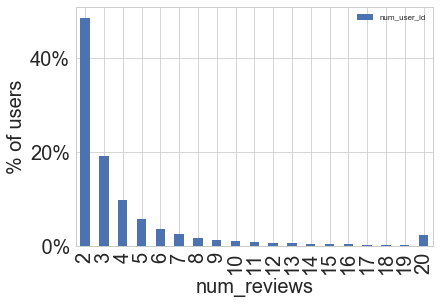

In [15]:
# show
num_reviews_per_var(reviews, 'user_id', 'review_id', 20, 'num_reviews', '% of users')

### User bias: some users tend to give higher ratings than others.
The histogram also shows differences in the average stars per user showing that some users tend to give higher ratings than others. These biases between users will be captured by our baseline model. 

In [17]:
users = pd.read_csv('data/user_final.csv',encoding = "ISO-8859-1")

user_ftres = [user_ftre for user_ftre in users.columns.tolist() if 'user_' in user_ftre]
y_user = 'user_average_stars'
user_compl_ftres = [ftre for ftre in user_ftres if 'user_compliment' in ftre]
user_count_ftres = ['user_cool', 'user_fans', 'user_funny', 'user_review_count', 'user_useful']
user_cat_ftres = ['user_elite_flag', 'user_friends_flag', 'yelping_since']

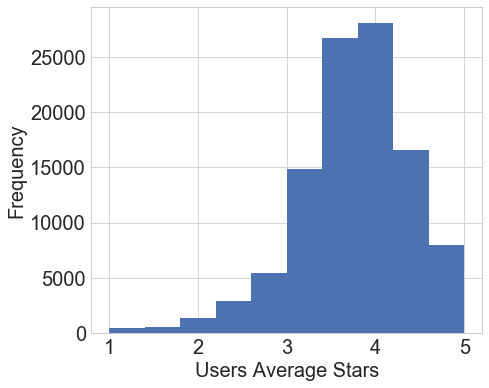

In [21]:
# show
fig, ax = plt.subplots(1,1, figsize=(7, 6))
users[y_user].plot(kind='hist', ax=ax)
ax.set_xlabel('Users Average Stars')
plt.show()

### Most businesses have more than 3 reviews.
Looking at business, the distribution of number of reviews per business is less ‘right-skewed’ and we have more restaurants with more than 3 reviews. 

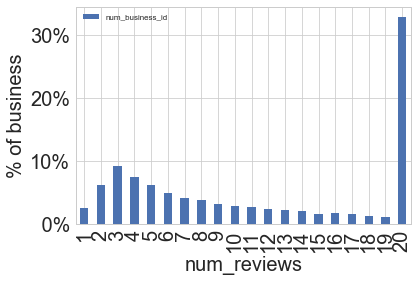

In [22]:
# show
num_reviews_per_var(reviews, 'business_id', 'review_id', 20, 'num_reviews', '% of business')

### Reducing the number of business categories
After expanding the business categories, we ended up with a dataframe of ~460 columns where each column was a distinct category. This number is too large, and we had to select categories that were more relevant to the goal of making recommendations to users. To find out which categories are most prominent and which are relevant for restaurant recommendation, we first got rid of the categories that only occur a few times in the dataset (the cutoff used was 11). These tended to be the ones not relevant to restaurants. Looking at the top 10 and bottom 10 categories in terms of number of occurrences, we found that the top 10 are mostly fast food or quick food places, and the bottom 10 are mostly ethnic food places. This gave us the idea that if two users like some of these rarely occurring restaurant categories, perhaps we could give them a greater weight when predicting/recommending the next restaurant. 

In [39]:
from sklearn.decomposition import PCA
sns.set_context('poster')
sns.set_style('white')
pd.set_option('display.max_columns', None)  

business_df = pd.read_csv('data/restaurants_final.csv', encoding='ISO-8859-1')

//anaconda/envs/snakes/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
busi_categories = ['Playgrounds',
       'Coffee & Tea', 'African', 'Jazz & Blues', 'Bagels', 'Coffeeshops',
       'Swimming Pools', 'Diners', 'Flea Markets', 'Fast Food', 'German',
       'Organic Stores', 'Dominican', 'Hot Dogs', 'Hotels & Travel',
       'Tea Rooms', 'Cheese Tasting Classes', 'Tasting Classes',
       'Gay Bars', 'Cupcakes', 'Art Classes', 'Beer Bar',
       'Coffee Roasteries', 'Cafeteria', 'Karaoke', 'Street Vendors',
       'Salad', 'Tapas/Small Plates', 'Poke', 'American (Traditional)',
       'Chocolatiers & Shops', 'Casinos', 'Notaries',
       'Country Dance Halls', 'Public Markets', 'Financial Services',
       'Drive-Thru Bars', 'Armenian', 'Popcorn Shops',
       'Adult Entertainment', 'Pasta Shops', 'Bowling', 'South African',
       'Gift Shops', 'Persian/Iranian', 'Golf', 'Beer Hall', 'Kosher',
       'Smokehouse', 'Basque', 'Landmarks & Historical Buildings',
       'Festivals', 'Amusement Parks', 'Eastern European', 'Gastropubs',
       'Do-It-Yourself Food', 'Puerto Rican', 'Fischbroetchen',
       'Creperies', 'New Mexican Cuisine', 'Wraps', 'Specialty Schools',
       'Fruits & Veggies', 'Japanese', 'British', 'Beer Garden',
       'Wineries', 'Arts & Crafts', 'Leisure Centers', 'Beer',
       'Wine & Spirits', 'Sandwiches', 'Fishmonger', 'Irish Pub',
       'Home Services', 'Social Clubs', 'Pop-up Shops', 'Polish',
       'Custom Cakes', 'Canadian (New)', 'Middle Eastern', 'Wine Bars',
       'Bistros', 'Hakka', 'Arcades', 'Halal', 'Trinidadian', 'Swabian',
       'Turkish', 'Food Stands', 'Breakfast & Brunch', 'Hookah Bars',
       'CSA', 'Alsatian', 'Chicken Shop', 'Airports', 'Shopping Centers',
       'Soul Food', 'Meat Shops', 'Dim Sum', 'Pita', 'Tabletop Games',
       'Moroccan', 'Knife Sharpening', 'Cafes', 'Food Trucks', 'Shopping',
       'Acai Bowls', 'Spanish', 'Cheesesteaks', 'Churches', 'Hungarian',
       'Cambodian', 'Hawaiian', 'Australian', 'Delis', 'Szechuan',
       'Music Venues', 'Pub Food', 'Malaysian', 'Special Education',
       'Chicken Wings', 'Juice Bars & Smoothies', 'Bed & Breakfast',
       'Swiss Food', 'Dance Clubs', 'Kids Activities', 'Local Flavor',
       'Flatbread', 'Gun/Rifle Ranges', 'Baden', 'Asian Fusion',
       'Laser Tag', 'Vegetarian', 'Colombian', 'Laotian', 'Olive Oil',
       'Delicatessen', 'Poutineries', 'Teppanyaki', 'Resorts', 'Afghan',
       'Seafood Markets', 'Scottish', 'Shared Office Spaces',
       'Cajun/Creole', 'Champagne Bars', 'Peruvian', 'Speakeasies',
       'Bavarian', 'Food Delivery Services', 'Breweries',
       'Ice Cream & Frozen Yogurt', 'Tapas Bars', 'Tours', 'Curry Sausage',
       'Taiwanese', 'Food Court', 'Vegan', 'Cocktail Bars', 'Brasseries',
       'Desserts', 'Steakhouses', 'Community Service/Non-Profit',
       'Vitamins & Supplements', 'Mountain Biking', 'Sugar Shacks',
       'Lounges', 'Art Galleries', 'French', 'Health Markets', 'Waffles',
       'Shaved Snow', 'Batting Cages', 'Sports Bars', 'Bakeries',
       'Beverage Store', 'Themed Cafes', 'Vietnamese',
       'Arts & Entertainment', 'Antiques', 'Czech', 'Cooking Schools',
       'Austrian', 'Patisserie/Cake Shop', 'Hong Kong Style Cafe', 'Ramen',
       'Sports Clubs', 'Mongolian', 'Shaved Ice', 'Tacos',
       'American (New)', 'Lebanese', 'Flowers & Gifts', 'Chinese',
       'Indian', 'Local Services', 'Ethnic Food', 'Himalayan/Nepalese',
       'Florists', 'Pizza', 'Club Crawl', 'Seafood', 'Argentine',
       'Tex-Mex', 'Brazilian', 'Egyptian', 'Sri Lankan',
       'Wine Tasting Room', 'Donuts', 'Wigs', 'Cuban', 'Active Life',
       'Salvadoran', 'Greek', 'Mulled Wine', 'Kiosk', 'Falafel',
       'Personal Shopping', 'Candy Stores', 'Pakistani', 'International',
       'Beer Gardens', 'Amateur Sports Teams', 'Gelato', 'Mosques', 'Pubs',
       'Comedy Clubs', 'Pool Halls', 'Southern', 'Imported Food',
       'Sushi Bars', 'Cheese Shops', 'Pan Asian', 'Bubble Tea',
       'Banks & Credit Unions', 'Education', 'Indonesian', 'Food Tours',
       'Coffee & Tea Supplies', 'Noodles', 'Fish & Chips', 'Kebab',
       'Milkshake Bars', 'Korean', 'Cabaret', 'Japanese Curry',
       'Farmers Market', 'Public Services & Government', 'Irish',
       'Parent Cafes', 'Latin American', 'Real Estate', 'Insurance',
       'Burgers', 'Wine Tours', 'Arabian', 'Buffets', 'Whiskey Bars',
       'Caribbean', 'Slovakian', 'Tuscan', 'Ukrainian', 'Distilleries',
       'Ethiopian', 'Izakaya', 'Financial Advising', 'Barbeque',
       'Religious Organizations', 'Cantonese', 'Empanadas', 'Hot Pot',
       'Modern European', 'Internet Cafes', 'Kombucha', 'Nightlife',
       'Thai', 'Bangladeshi', 'Bars', 'Venezuelan', 'Dive Bars', 'Fondue',
       'Guest Houses', 'Mediterranean', 'Belgian', 'Portuguese', 'Donairs',
       'Russian', 'Herbs & Spices', 'Mexican', 'Macarons', 'Cinema',
       'Butcher', 'Filipino', 'Pretzels', 'Reunion', 'Live/Raw Food',
       'Mini Golf', 'Scandinavian', 'Burmese', 'Yelp Events',
       'Specialty Food', 'Couriers & Delivery Services', 'Soup',
       'Singaporean', 'Comfort Food', 'Museums', 'Italian']

In [43]:
num_busi_cat = business_df[busi_categories].sum()

In [45]:
# only consider those with total counts greater than 11
num_busi_cat = num_busi_cat[num_busi_cat > 11]
num_busi_cat.sort_values(axis=0, ascending=False, inplace=True)

In [46]:
num_busi_cat = num_busi_cat.reset_index()
num_busi_cat.columns = ['category', 'count']

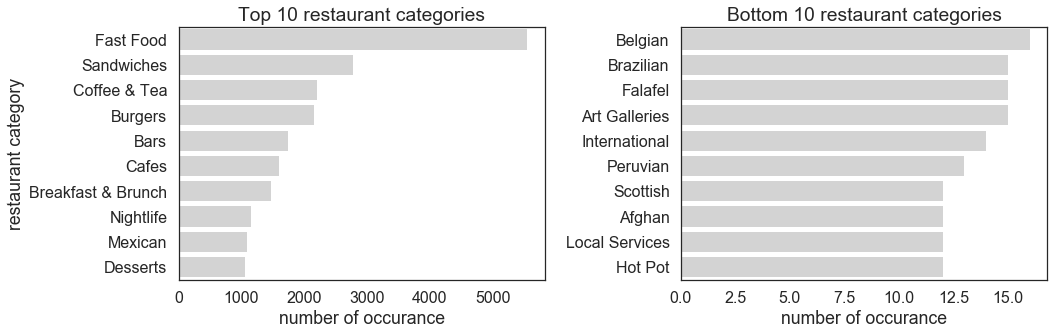

In [49]:
# show
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='count', y='category', data=num_busi_cat.head(10), color='lightgrey', ax=ax[0])
ax[0].set(ylabel='restaurant category')
ax[0].set(xlabel='number of occurance')
ax[0].set(title='Top 10 restaurant categories')
sns.barplot(x='count', y='category', data=num_busi_cat.tail(10), color='lightgrey', ax=ax[1])
ax[1].set(xlabel='number of occurance')
ax[1].set(title='Bottom 10 restaurant categories')
ax[1].set(ylabel='')
plt.tight_layout()
plt.show()

### Restaurant categories can be further reduced to a smaller set of dimensions. 
After getting rid of the categories that only occur a few times in the dataset, we still had ~180 restaurant categories. While this number is smaller than the original we started with (~460), we sought to further reduce the number by performing dimensionality reduction (specifically, PCA). By doing so, we obtained the first 30 principal components that explained ~75% of the total variance in the data. Looking at the first 3 PCs for visualization, we found that the top three categories (fast food, sandwiches, and coffee & tea) are nicely clustering in these spaces. Given these results, we think that dimensionality reduction could be a useful way to incorporate many features related to restaurants for finding similar restaurants in the recommendation system. 


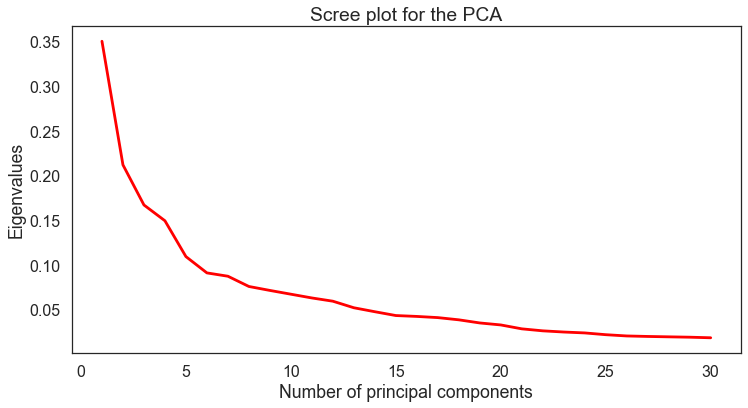

In [51]:
n_components = 30
pca = PCA(n_components=n_components)

tokeep = list(num_busi_cat['category'].values) + ['business_id']
business_df_sub = business_df[tokeep]
X = business_df_sub.drop(axis=1, inplace=False, labels=['business_id'])
X_pca = pca.fit_transform(X)

# # we make a scree plot to see how many Principal Components to consider
plt.figure(figsize=(12, 6))
eig = pca.explained_variance_

# # and calculate the variance explained by the PC analysis
var_exp = pca.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
plt.show()

In [56]:
v = var_exp[-1]
print("% variance explained by keeping 30 PCs:", v)

% variance explained by keeping 30 PCs: 78.1437630596


In [59]:
def plot_pca_results(pc1, pc2, feature_name):
    temp = pd.DataFrame([])
    temp['pc1'] = X_pca[:,pc1]
    temp['pc2'] = X_pca[:,pc2]
    temp['f'] = business_df_sub[feature_name]
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(temp[temp['f'] == False]['pc1'], temp[temp['f'] == False]['pc2'], 'o', label='no', alpha=0.5)
    ax.plot(temp[temp['f'] == True]['pc1'], temp[temp['f'] == True]['pc2'], 'o', label='yes', alpha=0.5, color='brown')
    ax.set(title=feature_name)
    ax.set(xlabel='principle component ' + str(pc1+1))
    ax.set(ylabel='principle component ' + str(pc2+1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

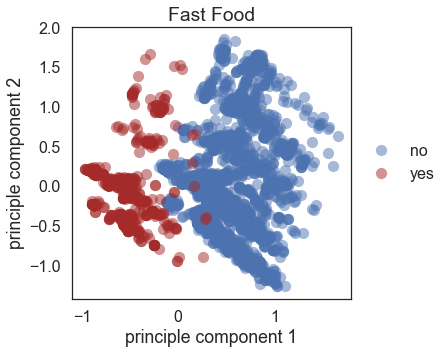

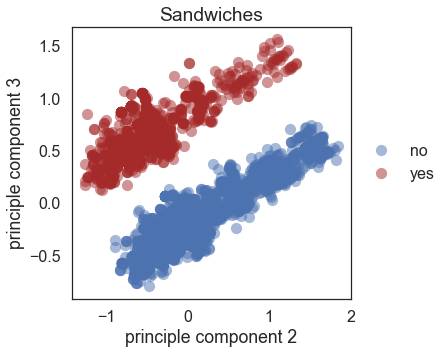

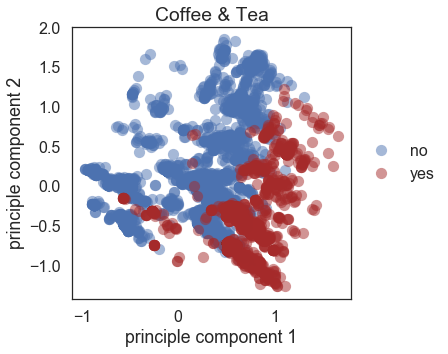

In [60]:
# show
feature_name = 'Fast Food'
plot_pca_results(0, 1, feature_name)
feature_name = 'Sandwiches'
plot_pca_results(1, 2, feature_name)
feature_name = 'Coffee & Tea'
plot_pca_results(0, 1, feature_name)

### Reducing the number of restaurant attributes
In addition to restaurant categories, there are restaurant attributes provided in the raw data. We expanded these into a Pandas dataframe and sought to filter down to those attributes that are more useful. We chose to filter out the attributes that are missing for most restaurants to reduce data sparsity. 


In [62]:
business_df = pd.read_csv('data/restaurants.csv', encoding='ISO-8859-1')

In [63]:
# first figure out the business with the longest attribute list. 
# use this as the template for expanding the attributes into a pandas dataframe for all businesses.
business_df['attri_length'] = business_df['attributes'].apply(lambda x: len(x))

# for the business with the longest attribute list, get the primary keys in the json 
# to parse through the attribute list and expand them into a dataframe. 

temp = business_df[business_df['attri_length'] == business_df['attri_length'].max()].attributes.values[0]
temp = re.sub("'", '"', temp)
temp = re.sub(" T", " t", temp)
temp = re.sub(" F", " f", temp)
j = json.loads(temp)

# save the attribute names as a list so that I can use this as a template for parsing through all businesses. 
cols = list()
for keys in j:
    cols.append(keys)

In [64]:
business_attributes = pd.DataFrame(columns=cols)

for i in range(len(business_df)):
    
    temp = business_df['attributes'][i]
    temp = re.sub("'", '"', temp)
    temp = re.sub(" T", " t", temp)
    temp = re.sub(" F", " f", temp)
    j = json.loads(temp)
    
    output = list()
    for c in cols:
        try: 
            output.append(j[c])
        except KeyError:
            output.append('unknown')      
            
    temp = pd.DataFrame(columns=cols)
    temp.loc[0] = output
    
    business_attributes = [business_attributes, temp]
    business_attributes = pd.concat(business_attributes)

In [65]:
business_attributes.reset_index(drop=True, inplace=True)

# Eliminate the attributes where the top level is 'unknown'. 
# This means that we don't have the information for the majority of restaurants. 
temp = business_attributes.drop(axis=1, inplace=False, labels=['BusinessParking', 'BestNights', 'Music', 'Ambience', 
                                                        'GoodForMeal', 'DietaryRestrictions']).describe()
meaningful_attributes = temp.loc['top'] != 'unknown'

### Exploring the relationship between different restaurant attributes/categories:
We explored the relationship between different attributes so that it would help us further narrow down the list of attributes we would keep for collaborative filtering. We found that higher the restaurant price range, more restaurants have dressy/formal attire attributes. Also higher the price range, more restaurants accept reservations. Given these relationships, we could eliminate reservation acceptance and attire features, and keep only the price range feature. In a similar manner, we found that the diversity of alcohol served and whether the restaurant is good for kids were negatively related (visualization not shown here), suggesting that only one of these features is needed due to their interaction. 


In [66]:
def makePercPivotTable(outercat, innercat, indexcat):
    
    temp = business_attributes.pivot_table(aggfunc='count', columns=[outercat, innercat])
    temp = temp.loc[indexcat]
    temp = temp.reset_index()
    temp.columns = [outercat, innercat, 'subcount']

    totalcount = business_attributes.pivot_table(aggfunc='count', columns=[outercat])
    totalcount = totalcount.loc[indexcat]
    totalcount = totalcount.reset_index()
    totalcount.columns = [outercat, 'totalcount']

    temp = pd.merge(left=temp, right=totalcount, how='left', on=[outercat])
    temp['perc'] = temp['subcount'] * 100. / temp['totalcount']
    
    return temp

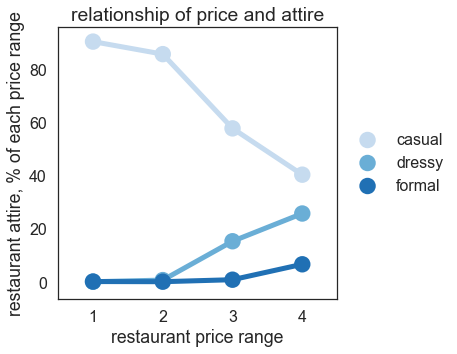

In [67]:
# show
temp = makePercPivotTable('RestaurantsPriceRange2', 'RestaurantsAttire', 'OutdoorSeating')
temp = temp[temp['RestaurantsPriceRange2']!='unknown']
temp = temp[temp['RestaurantsAttire']!='unknown']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.pointplot(x='RestaurantsPriceRange2', y='perc', hue='RestaurantsAttire',
              data=temp,
              palette='Blues', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel='restaurant price range')
ax.set(ylabel='restaurant attire, % of each price range')
ax.set(title='relationship of price and attire')
plt.show()

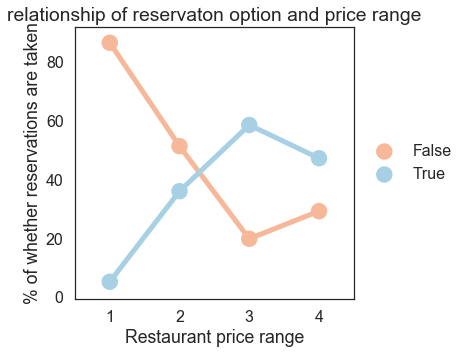

In [68]:
# show
temp = makePercPivotTable('RestaurantsPriceRange2', 'RestaurantsReservations', 'OutdoorSeating')
temp = temp[temp['RestaurantsReservations']!='unknown']
temp = temp[temp['RestaurantsPriceRange2']!='unknown']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.pointplot(x='RestaurantsPriceRange2', y='perc', hue='RestaurantsReservations', 
              data=temp, hue_order=[False, True],
              palette='RdBu' , ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel='Restaurant price range')
ax.set(ylabel='% of whether reservations are taken')
ax.set(title='relationship of reservaton option and price range')
plt.show()

On the other hand, the noise level of restaurants and whether it’s a good place for groups or it has a TV did not seem to have a strong positive or negative relationship. 

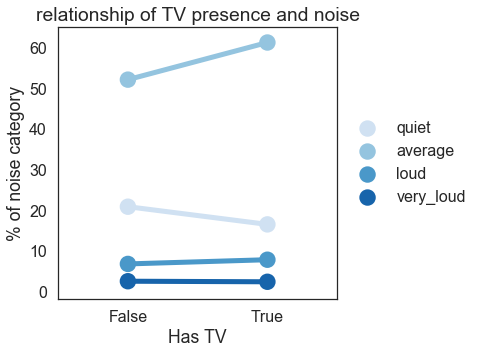

In [69]:
# show
temp = makePercPivotTable('HasTV', 'NoiseLevel', 'OutdoorSeating')
temp = temp[temp['HasTV']!='unknown']
temp = temp[temp['NoiseLevel']!='unknown']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.pointplot(x='HasTV', y='perc', hue='NoiseLevel',
              data=temp, hue_order=['quiet', 'average', 'loud', 'very_loud'],
              palette='Blues', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel='Has TV')
ax.set(ylabel='% of noise category')
ax.set(title='relationship of TV presence and noise')
plt.show()

### Exploring the relationship between user attributes and the avg. star rating of a user
For this purpose, we created 3 new features from the original features in the dataset:
- User_friends_flag that indicates if the user has at least one friend
- User_elite_flag that indicates if the user has been an “elite user” at least one
- The year since when the user is at Yelp

The 2 first features seemed to have some relationship with the average number of stars of the user but the year does not seem to be a factor. Other features from the user dataset has been explored but they did not seem to have a significant relationship with the avg. star rating. 

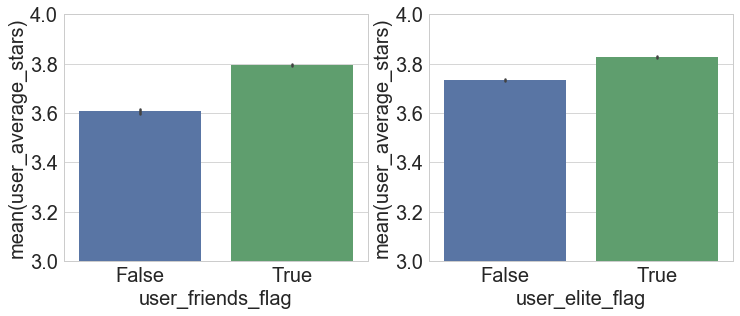

In [23]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
# f, ax = plt.subplots(1, 2, figsize=(10, 4))
g = sns.factorplot(x="user_friends_flag", y=y_user, data=users, kind='bar', ax=ax1);
ax1.set_ylim(3, 4);
plt.close(g.fig);
g = sns.factorplot(x="user_elite_flag", y=y_user, data=users, kind='bar', ax=ax2);
ax2.set_ylim(3, 4);
plt.close(g.fig);
plt.show();

<a id='review'></a>
[back to top](#top)

# Literature review / related work

## 1. Creating a baseline model
Before trying collaborative filtering which is based on user's experience with a particular restaurant, we first created a baseline model that captures the user's bias (e.g. some users are more likely to give higher ratings than others) and the bias of the restaurant (e.g. a restaurant could be a part of a national chain like Cheesecake Factory that has a higher brand power than Chipotle that recently suffered from mass infections). To this end, we relied on the method described in *Advances in Collaborative Filtering*, [(link)](https://datajobs.com/data-science-repo/Collaborative-Filtering-%5BKoren-and-Bell%5D.pdf) by Yehuda Koren's and Robert Bell.

## 2. Matrix factorization

- https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html
- https://towardsdatascience.com/how-to-build-a-simple-song-recommender-296fcbc8c85






<a id='modeling'></a>
[back to top](#top)

# Modeling approach and project trajectory

/// add a graphic here about baseline approach and what additional things we did

## I. Baseline modeling

Using the method described in *Advances in Collaborative Filtering*, [(link)](https://datajobs.com/data-science-repo/Collaborative-Filtering-%5BKoren-and-Bell%5D.pdf) by Yehuda Koren's and Robert Bell, we created a baseline model with user bias and restaurant bias terms. According to Koren and Bell, the baseline model can be expressed as the following:

$b_{u i} = \mu + b_{u} + b_{ i}$

where $\mu$ represents the mean of all ratings. $b_{u}$ and $b_{i}$ represent the observed deviation of user $u$ and item $i$, respectively. 

In order to find the parameters $b_{u}$ and $b_{i}$, we used two approaches: 

### approach 1: Use the formulas given in the paper to find the bias

$b_{i}$ = $\left(\frac{\sum u \epsilon R(i) (r_{ui} - \mu)}{\lambda_{2} + |R(i)|}\right)$

$b_{u}$ = $\left(\frac{\sum u \epsilon R(i) (r_{ui} - \mu)}{\lambda_{3} + |R(u)|}\right)$

Where $\lambda_{2}$ and $\lambda_{3}$ are the regularization parameters (to be chosen by cross-validation), R(i) represents all users who rated item $i$, and R(u) represents all items that user $u$ has rated.

### approach 2: Use Ridge regression to find the bias terms
We performed Ridge Regression using cross-validation.

## II. Matrix factorization


<a id='baseline'></a>
[back to top](#top)

## The baseline model

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from itertools import product
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time
import sys

In [4]:
recommendations_full = pd.read_csv('data/recommendations.csv',encoding = "ISO-8859-1",index_col=0)
sample = recommendations_full.sample(frac=0.1)

//anaconda/envs/snakes/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (37,39,40,41,42,43,44,46,47,48,51,52,53,54,56,57,59,60,61,63,65,66,69,70,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# get data in the appropriate format

"""
add_numerical_id()
-this function replaces string identifiers with numeric identifiers


inputs: dataframe, variable to be replaced, name of new variable
outputs: dataframe with new variables, dataframe with JUST the new variables
"""
#todo- we can probably remove df_var_id as an output
def add_numerical_id(df, var, new_var):
    # Get the list of Later, we'll change the user_id and business_id by numerical values
    unique_values = df[var].unique()
    n_unique_values = len(unique_values)
    df_var_id = pd.DataFrame(data=unique_values, index=range(0,n_unique_values), columns=[var])
    df_var_id.index.name = new_var
    df_var_id.reset_index(drop=False, inplace=True)
    df = df.merge(df_var_id, how='left', on=var)
    return df, df_var_id

In [6]:
"""
create_dummy_var()
--this function creates dummy variables and appends them to the dataframe


inputs: dataframe, list of variables to create dummy variables
outputs: updated dataframe, list of dummy variables that were created

"""
def create_dummy_var(df, list_vars):
    list_dummy_var = []
    for var in list_vars:
        dummy_vars = pd.get_dummies(df[var], prefix=var, drop_first=True)
        df = df.merge(dummy_vars, how='left', left_index=True, right_index=True)  
        list_dummy_var.extend(dummy_vars.columns.values)
    return df, list_dummy_var

In [7]:
cat_ftres = ['is_open', 'state', 'Fast Food', 'Sandwiches', 'Coffee & Tea',
             'Burgers', 'user_elite_flag', 'user_friends_flag']
sample, ftres_dummy = create_dummy_var(sample, cat_ftres)

# Adding numerical keys to identify both users and restaurants
sample, df_users_id = add_numerical_id(sample, 'user_id', 'user_id_key')
sample, df_rest_id = add_numerical_id(sample, 'business_id', 'business_id_key')

ftres_all = ['business_mean',
 'business_bias',
 'user_mean',
 'user_bias',
 'avg_review_stars',
 'user_id_key',
 'business_id_key',
 'review_stars',
 'user_id',
 'business_id',
 'is_open_1',
 'state_BW',
 'state_C',
 'state_EDH',        
 'state_FIF',
 'state_HLD',
 'state_IL',
 'state_MLN',
 'state_NC',
 'state_NV',
 'state_NYK',
 'state_OH',
 'state_ON',
 'state_PA',
 'state_QC',
 'state_SC',
 'state_WI',
 'state_WLN',
 'Fast Food_True',
 'Sandwiches_True',
 'Coffee & Tea_True',
 'Burgers_True',
 'user_elite_flag_True',
 'user_friends_flag_True']

### Approach 1:

These next two functions will be applied to the dataframes iteratively. That is, we will loop through possible lambda2 and lambda3 values, and use cross-validation to determine which combination is optimal.


These functions are defined here, but are not applied until Step 3, where we cross-validate.


In [8]:
def get_restaurant_offsets(df, rating, bus_id, bus_avg, lambda2):
    overall_avg = df[rating].mean()
    
    #top of equation
    
    df['individualRatingMinusAverage'] = df[rating] - overall_avg #temporary column
    summedDifference = df.groupby(bus_id)['individualRatingMinusAverage'].sum()
    
    df.drop('individualRatingMinusAverage',axis=1,inplace=True) #get rid of temporary column

    #bottom of equation
    ratingCount = df.groupby(bus_id)[rating].count()    
    
    #final result
    bias = pd.DataFrame(data=summedDifference / (ratingCount + lambda2),
                       columns=['business_bias'])
    
    #add result back to dataframe
    df = df.join(bias,on=bus_id)
    return df

In [9]:
def get_user_offsets(df, rating, user_id, user_avg, lambda3):
    overall_avg = df[rating].mean()
    
    #top of equation
    
    df['individualRatingMinusAverage'] = df[rating] - overall_avg #temporary column
    summedDifference = df.groupby(user_id)['individualRatingMinusAverage'].sum()
    
    df.drop('individualRatingMinusAverage',axis=1,inplace=True) #get rid of temporary column

    #bottom of equation
    ratingCount = df.groupby(user_id)[rating].count()    
    
    #final result
    bias = pd.DataFrame(data=summedDifference / (ratingCount + lambda3),
                       columns=['user_bias'])
    
    #add result back to dataframe
    df = df.join(bias,on=user_id)
    df['avg_review_stars'] = overall_avg
    return df

### Approach 2:

In [10]:
def add_bias(df, var, var_name, quant_var):
    overall_avg = df[quant_var].mean()
    df_bias = df.groupby(var, as_index=False).mean()[[var, quant_var]]
    var_mean = str(var_name+'_mean')
    var_bias = str(var_name+'_bias')
    df_bias.rename(columns={quant_var:var_mean}, inplace=True) 
    df_f = df.merge(df_bias, how='left', on=var)
    df_f[var_bias] = df_f[var_mean] - overall_avg
    df['avg_review_stars'] = overall_avg
    return df_f

### baseline model: comparison of approaches 1 & 2

In [11]:
"""
create_set()
-this variable transforms the training and test set into a matrix 
suitable for this regression

inputs: training dataset, test dataset, response variables, predictor features,
        index of category features

outputs: altered dataframe suitable for this regression

"""
def create_set(df_train, df_test, response, ftres, cat_ftres_index):
    dataset = {}
    dataset['response']      = response
    dataset['ftres']         = ftres
    
    # Response variable
    dataset['y_train'] = np.ravel(df_train[dataset['response']])
    dataset['y_test']  = np.ravel(df_test[dataset['response']])
    
    assert (type(ftres) == str or type(ftres) == list)
    if type(ftres) == list:
        dataset['X_train'] = df_train[dataset['ftres']].values
        dataset['X_test']  = df_test[dataset['ftres']].values        
    else:
        dataset['X_train'] = df_train[dataset['ftres']].values.reshape(-1,1)
        dataset['X_test']  = df_test[dataset['ftres']].values.reshape(-1,1)
    
    # All values must be float
    dataset['X_train'] = dataset['X_train'].astype(float)
    dataset['X_test'] = dataset['X_test'].astype(float)
    X_all = np.concatenate([dataset['X_train'], dataset['X_test']], axis=0)
    
    # Encode categorical variables in a sparse matrix
    encoder = OneHotEncoder(categorical_features=cat_ftres_index, sparse=True)
    encoder.fit(X_all)
    dataset['X_train_sparse'] = encoder.transform(dataset['X_train'])
    dataset['X_test_sparse'] = encoder.transform(dataset['X_test'])    
    return dataset

In [12]:
def boundaries_stars(x):
    return min(max(x, 1), 5)

In [13]:
"""
train_and_predict_model()
-this function takes a model, dataframe, and predictor/response information.
 it then fits the model and reports various scores of interest
 
inputs: regression model, dataframe/predictor/response information that is stored in a **set** variable
outputs: dictionary of relevant scores
"""
def train_and_predict_model(model, input_set):
    
    start = time.time()
    # Dictionary to save all the results
    m = dict()
    
    #initialize x and y for regression
    m['X_train'] = input_set['X_train']
    m['y_train'] = input_set['y_train']
    
    m['X_test'] = input_set['X_test']
    m['y_test'] = input_set['y_test']
    
    # Fit the model with sparse matrix
    model.fit(input_set['X_train_sparse'], m['y_train'])
    
    # Predict the values with the model in the training and test set 
    # restricting the values to the range (1,5)
    limit_values = np.vectorize(boundaries_stars)
    m['y_hat_train'] = limit_values(model.predict(input_set['X_train_sparse']))
    m['y_hat_test']  = limit_values(model.predict(input_set['X_test_sparse']))
    
    # Parameter of goodness of fit: MSE
    m['train_RMSE'] = np.sqrt(mean_squared_error(m['y_train'], m['y_hat_train']))
    m['test_RMSE'] = np.sqrt(mean_squared_error(m['y_test'], m['y_hat_test']))
    
    # Parameter of goodness of fit: R2
    m['train_r2'] = r2_score(m['y_train'], m['y_hat_train'])
    m['test_r2'] = r2_score(m['y_test'], m['y_hat_test'])
    
    size = 0
    for key in m: size+=sys.getsizeof(m[key])
    m['size'] = size
    m['runtime'] = time.time() - start
    return m

In [14]:
"""
cross_validate_lambda()
-this function uses the method described in Step2-Option1 to return statistical information
-for every lambda combination specified.

inputs: dataframe, predictor features, response variable, rating variable name,
        business_id column, business_average column,
        user_id column, user_average column,
        parameter dictionary specificying which lambda values to loop through,
        amount of folds to perform in cross-validation
        
outputs: dictionary storing the mean results from N-Fold cross validation in the following areas:
         -train_r2
         -train_RMSE
         -test_r2
         -test_RMSE

"""

def cross_validate_lambda(df, ftres_all, response, rating, bus_id, bus_avg, user_id, user_avg,
                          param_dict, nfolds):
    
    scoreDict={}
    for lambda2, lambda3 in product(*param_dict.values()):
        join1 = get_restaurant_offsets(df, rating, bus_id, bus_avg, lambda2)
        join2 = get_user_offsets(join1, rating, user_id, user_avg, lambda3)
        
        sets = {}
        #return ftres_all

        
        train_r2 = []
        test_r2 = []
        train_RMSE = []
        test_RMSE = []
        for f_train, f_val in KFold(n_splits=nfolds, shuffle=True, random_state=9001).split(join2.index):
            train_split = join2.iloc[f_train]
            val_split = join2.iloc[f_val]
            
            sets['bsln'] = create_set(train_split, val_split, 'review_stars', ftres_all, [5,6])
            
            allScores = train_and_predict_model(LinearRegression(), sets['bsln'])
            
            train_r2.append(allScores['train_r2'])
            train_RMSE.append(allScores['train_RMSE'])
            
            test_r2.append(allScores['test_r2'])
            test_RMSE.append(allScores['test_RMSE'])
        scoreDict[lambda2, lambda3] = {'train_r2':np.mean(train_r2),
                                       'train_RMSE':np.mean(train_RMSE),
                                       'test_r2':np.mean(test_r2),
                                       'test_RMSE':np.mean(test_RMSE)}
        

    return scoreDict

In [15]:
param_dict = OrderedDict(lambda2 = [i*5 for i in range(10)],
                        lambda3=[i*5 for i in range(10)])

Step2_Option1_Results = cross_validate_lambda(df=sample, ftres_all=ftres_all, response=['review_stars'], 
                                     rating='review_stars', bus_id='business_id', bus_avg='stars', 
                                     user_id='user_id', user_avg='user_average_stars', param_dict=param_dict, nfolds=5)

KeyError: "['business_mean' 'user_mean' 'is_open_1' 'state_FIF'] not in index"

In [ ]:
Step2_Option1_Results_DF = pd.DataFrame(Step2_Option1_Results)
print(Step2_Option1_Results_DF.loc['test_r2',:].idxmax())
print(Step2_Option1_Results_DF.loc['test_RMSE',:].idxmin())

(lambda2,lambda3) values of (0,0) return the highest test r-squared and the lowest test RMSE.

In [ ]:
# show
Step2_Option1_Results_DF.loc[:,(0,0)]

In [ ]:
Step2_Option2_DF = add_bias(sample, 'business_id', 'business', 'review_stars')
Step2_Option2_DF = add_bias(Step2_Option2_DF, 'user_id', 'user', 'review_stars')

#Step2_Option2_DF.drop(['business_id','user_id','review_stars'],axis=1,inplace=True)        
ftres_all.remove('business_id')
ftres_all.remove('user_id')
ftres_all.remove('review_stars')

df_train, df_test = train_test_split(Step2_Option2_DF[ftres_all + ['review_stars']], test_size=0.25, random_state=777)
sets={}
sets['bsln'] = create_set(df_train, df_test, 'review_stars', ftres_all, [5,6])

In [ ]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5, scoring=None):
    if not scoring:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=scoring)
    gs.fit(Xtrain, ytrain)
    return gs

def cv_optimize_with_sets(clf, parameters, sets, model_name, param_name, n_folds=5, scoring=None):
    Xtrain, Xtest = sets['X_train_sparse'], sets['X_test_sparse']
    ytrain, ytest = sets['y_train'], sets['y_test']
    gs = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, scoring=scoring)
    limit_values = np.vectorize(boundaries_stars)
    ytrain_hat = limit_values(gs.predict(Xtrain))
    ytest_hat = limit_values(gs.predict(Xtest))
    # R2
    train_r2 = r2_score(ytrain, ytrain_hat)
    test_r2 = r2_score(ytest, ytest_hat)
    # RMSE
    train_RMSE = np.sqrt(mean_squared_error(ytrain, ytrain_hat))
    test_RMSE = np.sqrt(mean_squared_error(ytest, ytest_hat))
    print("""{}. Best parameter: {}={}. 
                 Train R2:{:2.2f}% Test R2:{:2.2f}% 
                 Train RMSE: {:0.3f}. Test RSME: {:0.3f}""".format(
                 model_name, param_name, gs.best_params_[param_name],
                 train_r2, test_r2, train_RMSE, test_RMSE))
    return gs, gs.best_params_[param_name], train_r2, test_r2, train_RMSE, test_RMSE

In [ ]:
print('\n')
alphas = [ 0, 1,]
ridge = Ridge(fit_intercept=False)
gs, blsn2_alpha,train_r2, test_r2,train_RMSE, test_RMSE = cv_optimize_with_sets(ridge, {"alpha": alphas},
                                                        sets['bsln'], "Ridge Linear Regr Model",
                                                        "alpha", n_folds=5, 
                                                        scoring="neg_mean_squared_error")